In [ ]:
# default_exp kp2d

# KP2D

> Mostly copyied from KP2D [official repo](https://github.com/TRI-ML/KP2D)

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvf
from local_feature_tutorial.wbs import *
from local_feature_tutorial.io import *
KP2D_License= '''
MIT License

Copyright (c) 2019 Toyota Research Institute (TRI)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
'''
# Copyright 2020 Toyota Research Institute.  All rights reserved.

from functools import lru_cache

import torch
import torch.nn.functional as F


@lru_cache(maxsize=None)
def meshgrid(B, H, W, dtype, device, normalized=False):
    """Create mesh-grid given batch size, height and width dimensions.

    Parameters
    ----------
    B: int
        Batch size
    H: int
        Grid Height
    W: int
        Batch size
    dtype: torch.dtype
        Tensor dtype
    device: str
        Tensor device
    normalized: bool
        Normalized image coordinates or integer-grid.

    Returns
    -------
    xs: torch.Tensor
        Batched mesh-grid x-coordinates (BHW).
    ys: torch.Tensor
        Batched mesh-grid y-coordinates (BHW).
    """
    if normalized:
        xs = torch.linspace(-1, 1, W, device=device, dtype=dtype)
        ys = torch.linspace(-1, 1, H, device=device, dtype=dtype)
    else:
        xs = torch.linspace(0, W-1, W, device=device, dtype=dtype)
        ys = torch.linspace(0, H-1, H, device=device, dtype=dtype)
    ys, xs = torch.meshgrid([ys, xs])
    return xs.repeat([B, 1, 1]), ys.repeat([B, 1, 1])


@lru_cache(maxsize=None)
def image_grid(B, H, W, dtype, device, ones=True, normalized=False):
    """Create an image mesh grid with shape B3HW given image shape BHW

    Parameters
    ----------
    B: int
        Batch size
    H: int
        Grid Height
    W: int
        Batch size
    dtype: str
        Tensor dtype
    device: str
        Tensor device
    ones : bool
        Use (x, y, 1) coordinates
    normalized: bool
        Normalized image coordinates or integer-grid.

    Returns
    -------
    grid: torch.Tensor
        Mesh-grid for the corresponding image shape (B3HW)
    """
    xs, ys = meshgrid(B, H, W, dtype, device, normalized=normalized)
    coords = [xs, ys]
    if ones:
        coords.append(torch.ones_like(xs))  # BHW
    grid = torch.stack(coords, dim=1)  # B3HW
    return grid


def to_gray_normalized(images):
    """Performs image normalization and converts images to grayscale (preserving dimensions)
    
    Parameters
    ----------
    images: torch.Tensor
        Input images.

    Returns
    -------
    normalized_images: torch.Tensor
        Normalized grayscale images.
    """
    assert len(images.shape) == 4
    images -= 0.5
    images *= 0.225
    normalized_images = images.mean(1).unsqueeze(1) 
    return normalized_images


def to_color_normalized(images):
    """Performs image normalization and converts images to grayscale (preserving dimensions)
    
    Parameters
    ----------
    images: torch.Tensor
        Input images.

    Returns
    -------
    normalized_images: torch.Tensor
        Normalized grayscale images.
    """
    assert len(images.shape) == 4
    images -= 0.5
    images *= 0.225
    return images


class KeypointNet(torch.nn.Module):
    """
    Keypoint detection network.

    Parameters
    ----------
    use_color : bool
        Use color or grayscale images.
    do_upsample: bool
        Upsample desnse descriptor map.
    with_drop : bool
        Use dropout.
    do_cross: bool
        Predict keypoints outside cell borders.
    kwargs : dict
        Extra parameters
    """

    def __init__(self, use_color=True, do_upsample=True, with_drop=True, do_cross=True, **kwargs):
        super().__init__()

        self.training = True

        self.use_color = use_color
        self.with_drop = with_drop
        self.do_cross = do_cross
        self.do_upsample = do_upsample

        if self.use_color:
            c0 = 3
        else:
            c0 = 1

        self.bn_momentum = 0.1
        self.cross_ratio = 2.0

        if self.do_cross is False:
            self.cross_ratio = 1.0

        c1, c2, c3, c4, c5, d1 = 32, 64, 128, 256, 256, 512

        self.conv1a = torch.nn.Sequential(torch.nn.Conv2d(c0, c1, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c1,momentum=self.bn_momentum))
        self.conv1b = torch.nn.Sequential(torch.nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c1,momentum=self.bn_momentum))
        self.conv2a = torch.nn.Sequential(torch.nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c2,momentum=self.bn_momentum))
        self.conv2b = torch.nn.Sequential(torch.nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c2,momentum=self.bn_momentum))
        self.conv3a = torch.nn.Sequential(torch.nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c3,momentum=self.bn_momentum))
        self.conv3b = torch.nn.Sequential(torch.nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c3,momentum=self.bn_momentum))
        self.conv4a = torch.nn.Sequential(torch.nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c4,momentum=self.bn_momentum))
        self.conv4b = torch.nn.Sequential(torch.nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c4,momentum=self.bn_momentum))

        # Score Head.
        self.convDa = torch.nn.Sequential(torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c4,momentum=self.bn_momentum))
        self.convDb = torch.nn.Conv2d(c5, 1, kernel_size=3, stride=1, padding=1)

        # Location Head.
        self.convPa = torch.nn.Sequential(torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c4,momentum=self.bn_momentum))
        self.convPb = torch.nn.Conv2d(c5, 2, kernel_size=3, stride=1, padding=1)

        # Desc Head.
        self.convFa = torch.nn.Sequential(torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c4,momentum=self.bn_momentum))
        self.convFb = torch.nn.Sequential(torch.nn.Conv2d(c5, d1, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(d1,momentum=self.bn_momentum))
        self.convFaa = torch.nn.Sequential(torch.nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1, bias=False), torch.nn.BatchNorm2d(c5,momentum=self.bn_momentum))
        self.convFbb = torch.nn.Conv2d(c5, 256, kernel_size=3, stride=1, padding=1)

        self.relu = torch.nn.LeakyReLU(inplace=True)
        if self.with_drop:
            self.dropout = torch.nn.Dropout2d(0.2)
        else:
            self.dropout = None
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.cell = 8
        self.upsample = torch.nn.PixelShuffle(upscale_factor=2)

    def forward(self, x):
        """
        Processes a batch of images.

        Parameters
        ----------
        x : torch.Tensor
            Batch of input images (B, 3, H, W)

        Returns
        -------
        score : torch.Tensor
            Score map (B, 1, H_out, W_out)
        coord: torch.Tensor
            Keypoint coordinates (B, 2, H_out, W_out)
        feat: torch.Tensor
            Keypoint descriptors (B, 256, H_out, W_out)
        """
        B, _, H, W = x.shape

        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        if self.dropout:
            x = self.dropout(x)
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        if self.dropout:
            x = self.dropout(x)
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        skip = self.relu(self.conv3b(x))
        if self.dropout:
            skip = self.dropout(skip)
        x = self.pool(skip)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        if self.dropout:
            x = self.dropout(x)

        B, _, Hc, Wc = x.shape

        score = self.relu(self.convDa(x))
        if self.dropout:
            score = self.dropout(score)
        score = self.convDb(score).sigmoid()

        border_mask = torch.ones(B, Hc, Wc)
        border_mask[:, 0] = 0
        border_mask[:, Hc - 1] = 0
        border_mask[:, :, 0] = 0
        border_mask[:, :, Wc - 1] = 0
        border_mask = border_mask.unsqueeze(1)
        score = score * border_mask.to(score.device)

        center_shift = self.relu(self.convPa(x))
        if self.dropout:
            center_shift = self.dropout(center_shift)
        center_shift = self.convPb(center_shift).tanh()

        step = (self.cell-1) / 2.
        center_base = image_grid(B, Hc, Wc,
                                 dtype=center_shift.dtype,
                                 device=center_shift.device,
                                 ones=False, normalized=False).mul(self.cell) + step

        coord_un = center_base.add(center_shift.mul(self.cross_ratio * step))
        coord = coord_un.clone()
        coord[:, 0] = torch.clamp(coord_un[:, 0], min=0, max=W-1)
        coord[:, 1] = torch.clamp(coord_un[:, 1], min=0, max=H-1)

        feat = self.relu(self.convFa(x))
        if self.dropout:
            feat = self.dropout(feat)
        if self.do_upsample:
            feat = self.upsample(self.convFb(feat))
            feat = torch.cat([feat, skip], dim=1)
        feat = self.relu(self.convFaa(feat))
        feat = self.convFbb(feat)

        if self.training is False:
            coord_norm = coord[:, :2].clone()
            coord_norm[:, 0] = (coord_norm[:, 0] / (float(W-1)/2.)) - 1.
            coord_norm[:, 1] = (coord_norm[:, 1] / (float(H-1)/2.)) - 1.
            coord_norm = coord_norm.permute(0, 2, 3, 1)

            feat = torch.nn.functional.grid_sample(feat, coord_norm)

            dn = torch.norm(feat, p=2, dim=1)  # Compute the norm.
            feat = feat.div(torch.unsqueeze(dn, 1))  # Divide by norm to normalize.
        return score, coord, feat


In [ ]:
#export
import cv2
import os
class KP2DTwoViewMatcher(TwoViewMatcher):
    def __init__(self, matcher: DescriptorMatcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED),
                       geom_verif: GeometricVerifier = CV2_RANSACVerifier(0.5),
                weights_version='v4', num_kp=1000):
        weights_fname = 'pretrained_models.tar.gz'
        url_weights = 'https://tri-ml-public.s3.amazonaws.com/github/kp2d/models/pretrained_models.tar.gz'
        weights_path = download_file(url_weights, weights_fname)
        untar_to(weights_path, DOWNLOAD_DIR)
        weights_fname = os.path.join(DOWNLOAD_DIR, f'{weights_version}.ckpt')
        
        checkpoint = torch.load(weights_fname)
        model_args = checkpoint['config']['model']['params']

        # Create and load disp net
        self.keypoint_net = KeypointNet(use_color=model_args['use_color'],
                                   do_upsample=model_args['do_upsample'],
                                   do_cross=model_args['do_cross'])
        self.keypoint_net.load_state_dict(checkpoint['state_dict'])

        self.matcher = matcher
        self.geom_verif = geom_verif
        self.keypoint_net.eval()
        self.use_color = model_args['use_color']
        self.num_kp = num_kp
        return
    def verify(self, img1_fname, img2_fname):
        conf_threshold = 0.
        import kornia as K
        if type(img1_fname) is str:
            img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
        else:
            img1 = img1_fname
        if type(img2_fname) is str:
            img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)
        else:
            img2 = img2_fname
        
        if not self.use_color:
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
        if self.use_color:    
            timg1 = to_color_normalized(K.image_to_tensor(img1, False).float()/255.)
            timg2 = to_color_normalized(K.image_to_tensor(img2, False).float()/255.)
        else:
            timg1 = to_gray_normalized(K.image_to_tensor(img1, False).float()/255.)
            timg2 = to_gray_normalized(K.image_to_tensor(img2, False).float()/255.)
            
        with torch.no_grad():
            score_1, coord_1, desc1 = self.keypoint_net(timg1)
            score_2, coord_2, desc2 = self.keypoint_net(timg2)
            B, _, Hc, Wc = desc1.shape

            # Scores & Descriptors
            score_1 = torch.cat([coord_1, score_1], dim=1).view(3, -1).t().cpu().numpy()
            score_2 = torch.cat([coord_2, score_2], dim=1).view(3, -1).t().cpu().numpy()
            desc1 = desc1.view(256, Hc, Wc).view(256, -1).t().cpu().numpy()
            desc2 = desc2.view(256, Hc, Wc).view(256, -1).t().cpu().numpy()
            
            top_k1 =  np.argsort(score_1[:, 2])[::-1]
            good_idxs1 = top_k1[:self.num_kp]
            xy1 = score_1[good_idxs1,:2]
            descs1 = desc1[good_idxs1, :]
            
            top_k2 =  np.argsort(score_2[:, 2])[::-1]
            good_idxs2 = top_k2[:self.num_kp]
            xy2 = score_2[good_idxs2,:2]
            descs2 = desc2[good_idxs2, :]

        
        kps1 = [cv2.KeyPoint(pt[0], pt[1], 32) for pt in xy1]
        kps2 = [cv2.KeyPoint(pt[0], pt[1], 32) for pt in xy2]
        
        tentative_matches = self.matcher.match(descs1,
                                               descs2)
        
        src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentative_matches]).reshape(-1,2)
        dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentative_matches]).reshape(-1,2)
    
        F, mask = self.geom_verif.verify(src_pts, dst_pts)
        
        good_kpts1 = [ kps1[m.queryIdx] for i,m in enumerate(tentative_matches) if mask[i]]
        good_kpts2 = [ kps2[m.trainIdx] for i,m in enumerate(tentative_matches) if mask[i]]
        result = {'match_kpts1': good_kpts1, 
                  'match_kpts2': good_kpts2,
                  'F': F,
                  'num_inl': len(good_kpts1),
                 "tentative_pts1": src_pts,
                  "tentative_pts2": dst_pts}
        return result

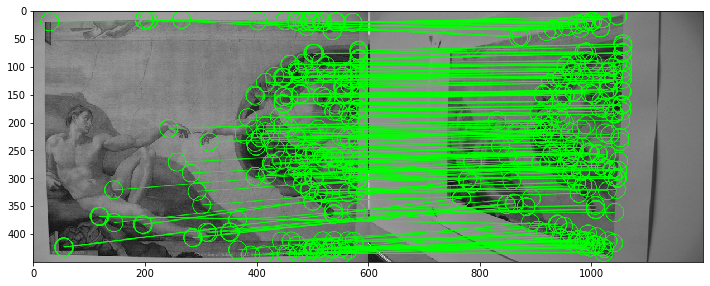

In [ ]:
from wbs_tutorial.visualization import *
wbs = KP2DTwoViewMatcher(matcher=SNNMatcher(0.95),
        geom_verif=degensac_Verifier())
res = wbs.verify('/home/old-ufo/Dropbox/HP/v_adam/1.ppm', 
                 '/home/old-ufo/Dropbox/HP/v_adam/6.ppm')

draw_matches_cv2(res['match_kpts1'], res['match_kpts2'],
                '/home/old-ufo/Dropbox/HP/v_adam/1.ppm', 
                '/home/old-ufo/Dropbox/HP/v_adam/6.ppm')

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted KP2D.ipynb.
Converted datasets.ipynb.
Converted index.ipynb.
Converted io.ipynb.
Converted retrieval.ipynb.
Converted visualization.ipynb.
Converted wbs.ipynb.
